<a href="https://colab.research.google.com/github/ritusuhasshetkar/ADA_Project/blob/main/Phase0_Getting_the_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data from Recipe 1M


Getting the data from Layers and it lives here [in this Google drive](https://drive.google.com/drive/folders/1hmbvG68V-2HguONcxikbioXBbZ-ZrFBu?usp=drive_link)**bold text**

In [ ]:
import json
import pickle
import os
import requests
import concurrent.futures
from collections import defaultdict
from tqdm.notebook import tqdm

# --- CONFIGURATION ---
BASE_DIR = '/content/drive/MyDrive/ADA_Project'
OUTPUT_DIR = os.path.join(BASE_DIR, 'recipe1m_subset_balanced')
IMAGES_DIR = os.path.join(OUTPUT_DIR, 'images')
DATA_FILE = os.path.join(OUTPUT_DIR, 'metadata.json')
TARGET_COUNT = 50000
MAX_WORKERS = 16

def get_actual_path(filename_start):
    """Finds the file regardless of extension (.pkl, .txt, etc)"""
    if not os.path.exists(BASE_DIR):
        print(f"❌ Error: The folder '{BASE_DIR}' does not exist.")
        return None

    for f in os.listdir(BASE_DIR):
        if f.startswith(filename_start):
            full_path = os.path.join(BASE_DIR, f)
            print(f"✅ Found file: {f}")
            return full_path
    return None

def main():
    # 1. FIND THE FILES AUTOMATICALLY
    print("🔍 Scanning folder for files...")

    class_path = get_actual_path("classes1M")
    if not class_path:
        print("❌ CRITICAL: Could not find any file starting with 'classes1M' in ADA_Project.")
        print("   Try clicking the 'Refresh' folder icon on the left sidebar.")
        return

    layer1_path = os.path.join(BASE_DIR, 'layer1.json')
    layer2_path = os.path.join(BASE_DIR, 'layer2.json')

    # 2. LOAD DATA
    print("⏳ Loading datasets...")

    # Load Classes
    with open(class_path, 'rb') as f:
        class_map = pickle.load(f, encoding='latin1')

    # Load Text
    with open(layer1_path, 'r') as f:
        # Optimization: Read directly into dict
        text_map = {item['id']: item for item in json.load(f)}

    # Load Images
    with open(layer2_path, 'r') as f:
        image_map = {item['id']: item for item in json.load(f)}

    print("✅ All files loaded. Organizing by Class...")

    # 3. GROUP VALID RECIPES
    class_buckets = defaultdict(list)
    valid_count = 0

    for rid, class_id in class_map.items():
        if rid in text_map and rid in image_map:
            imgs = image_map[rid].get('images', [])
            if len(imgs) > 0:
                recipe_data = text_map[rid].copy()
                recipe_data['image_url'] = imgs[0]['url']
                recipe_data['class_id'] = class_id

                class_buckets[class_id].append(recipe_data)
                valid_count += 1

    print(f"📊 Found {valid_count} valid candidates across {len(class_buckets)} classes.")

    # 4. ROUND-ROBIN SELECTION
    print("⚖️ Selecting balanced subset...")
    selected_items = []
    class_ids = list(class_buckets.keys())

    if not os.path.exists(IMAGES_DIR):
        os.makedirs(IMAGES_DIR)

    while len(selected_items) < TARGET_COUNT and len(class_ids) > 0:
        for cid in list(class_ids):
            if not class_buckets[cid]:
                class_ids.remove(cid)
                continue

            selected_items.append(class_buckets[cid].pop(0))
            if len(selected_items) >= TARGET_COUNT:
                break

    print(f"🚀 Selected {len(selected_items)} balanced recipes. Starting download...")

    # 5. DOWNLOAD
    final_dataset = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        futures = {executor.submit(download_image, item): item for item in selected_items}

        with tqdm(total=len(selected_items)) as pbar:
            for future in concurrent.futures.as_completed(futures):
                result = future.result()
                if result:
                    final_dataset.append(result)
                pbar.update(1)

    # 6. SAVE METADATA
    with open(DATA_FILE, 'w') as f:
        json.dump(final_dataset, f, indent=4)

    print(f"🎉 DONE! Saved balanced dataset to {OUTPUT_DIR}")

def download_image(item):
    url = item.get('image_url')
    path = os.path.join(IMAGES_DIR, f"{item['id']}.jpg")

    if os.path.exists(path) and os.path.getsize(path) > 2000:
        item['local_path'] = path
        return item

    try:
        r = requests.get(url, timeout=4, stream=True)
        if r.status_code == 200:
            with open(path, 'wb') as f:
                for chunk in r.iter_content(1024):
                    f.write(chunk)
            if os.path.getsize(path) > 2000:
                item['local_path'] = path
                return item
            else:
                os.remove(path)
    except:
        pass
    return None

if __name__ == "__main__":
    main()

🔍 Scanning folder for files...
✅ Found file: classes1M.pkl
⏳ Loading datasets...
✅ All files loaded. Organizing by Class...
📊 Found 402760 valid candidates across 1048 classes.
⚖️ Selecting balanced subset...
🚀 Selected 50000 balanced recipes. Starting download...


  0%|          | 0/50000 [00:00<?, ?it/s]

🎉 DONE! Saved balanced dataset to /content/drive/MyDrive/ADA_Project/recipe1m_subset_balanced


In [ ]:
import json
import os
import pickle
from tqdm.notebook import tqdm

# --- CONFIGURATION ---
BASE_DIR = '/content/drive/MyDrive/ADA_Project'
OUTPUT_DIR = os.path.join(BASE_DIR, 'recipe1m_subset_balanced') # Ensure this matches your folder
IMAGES_DIR = os.path.join(OUTPUT_DIR, 'images')
DATA_FILE = os.path.join(OUTPUT_DIR, 'metadata.json')

# Input Paths
LAYER1_PATH = os.path.join(BASE_DIR, 'layer1.json')
# Try to find class file (manual or drive)
CLASS_PATH = '/content/classes1M.pkl' if os.path.exists('/content/classes1M.pkl') else os.path.join(BASE_DIR, 'classes1M.pkl')

def main():
    print("🕵️‍♀️ Checking downloaded images...")

    if not os.path.exists(IMAGES_DIR):
        print(f"❌ Error: Image folder not found at {IMAGES_DIR}")
        return

    # 1. Get list of downloaded IDs
    downloaded_files = os.listdir(IMAGES_DIR)
    downloaded_ids = set([f.split('.')[0] for f in downloaded_files if f.endswith('.jpg')])

    print(f"✅ Found {len(downloaded_ids)} images on disk.")

    if len(downloaded_ids) == 0:
        print("⚠️ No images found. You need to run the downloader script first.")
        return

    # 2. Load Original Data
    print("⏳ Loading original layers to rebuild metadata...")

    with open(LAYER1_PATH, 'r') as f:
        # Create lookup: ID -> Recipe Data
        text_map = {item['id']: item for item in json.load(f)}

    # Load Classes if available
    class_map = {}
    if os.path.exists(CLASS_PATH):
        print("   Loading classes...")
        with open(CLASS_PATH, 'rb') as f:
            class_map = pickle.load(f, encoding='latin1')
    else:
        print("⚠️ Warning: classes1M.pkl not found. Metadata will lack class IDs.")

    # 3. Rebuild Metadata
    print("🔨 Reconstructing metadata.json...")
    restored_data = []

    for rid in tqdm(downloaded_ids):
        if rid in text_map:
            entry = text_map[rid].copy()

            # Add Local Path
            entry['local_path'] = os.path.join(IMAGES_DIR, f"{rid}.jpg")

            # Add Class (if we have it)
            if rid in class_map:
                entry['class_id'] = class_map[rid]

            restored_data.append(entry)

    # 4. Save
    print(f"💾 Saving {len(restored_data)} entries to {DATA_FILE}...")
    with open(DATA_FILE, 'w') as f:
        json.dump(restored_data, f, indent=4)

    print("🎉 RECOVERY COMPLETE! You now have a working metadata.json.")

if __name__ == "__main__":
    main()

🕵️‍♀️ Checking downloaded images...
✅ Found 29932 images on disk.
⏳ Loading original layers to rebuild metadata...
   Loading classes...
🔨 Reconstructing metadata.json...


  0%|          | 0/29932 [00:00<?, ?it/s]

💾 Saving 29932 entries to /content/drive/MyDrive/ADA_Project/recipe1m_subset_balanced/metadata.json...
🎉 RECOVERY COMPLETE! You now have a working metadata.json.


In [ ]:
import json
import os
import pickle
from tqdm.notebook import tqdm

# --- CONFIGURATION ---
BASE_DIR = '/content/drive/MyDrive/ADA_Project'
IMAGES_DIR = os.path.join(BASE_DIR, 'recipe1m_subset_balanced', 'images')
OUTPUT_FILE = os.path.join(BASE_DIR, 'recipe1m_subset_balanced', 'metadata.json')

# Input Data Paths
LAYER1_PATH = os.path.join(BASE_DIR, 'layer1.json')

# We check local upload FIRST (safest), then Drive
if os.path.exists('/content/classes1M.pkl'):
    CLASS_PATH = '/content/classes1M.pkl'
    print("✅ Found 'classes1M.pkl' in local uploads.")
elif os.path.exists(os.path.join(BASE_DIR, 'classes1M.pkl')):
    CLASS_PATH = os.path.join(BASE_DIR, 'classes1M.pkl')
    print("✅ Found 'classes1M.pkl' in Drive.")
else:
    CLASS_PATH = None
    print("⚠️ WARNING: 'classes1M.pkl' not found. Your metadata will NOT have class labels.")

def main():
    # 1. Scan the Disk for Images
    print("file_scan: Reading image folder...")
    if not os.path.exists(IMAGES_DIR):
        print("❌ Error: Image folder missing.")
        return

    # Get all .jpg files without the extension
    downloaded_ids = [f.split('.')[0] for f in os.listdir(IMAGES_DIR) if f.endswith('.jpg')]
    print(f"   Found {len(downloaded_ids)} images.")

    # 2. Load the Master Lists
    print("data_load: Loading text and classes...")

    with open(LAYER1_PATH, 'r') as f:
        # Create a dictionary for instant lookup: ID -> Recipe Data
        text_map = {item['id']: item for item in json.load(f)}

    class_map = {}
    if CLASS_PATH:
        with open(CLASS_PATH, 'rb') as f:
            class_map = pickle.load(f, encoding='latin1')

    # 3. Connect Them (The "Merger")
    print("connecting: Linking Images ↔ Text ↔ Classes...")
    rebuilt_metadata = []

    for rid in tqdm(downloaded_ids):
        # Only process if we have text for this image
        if rid in text_map:
            entry = text_map[rid].copy()

            # Add the local path (so your VLM knows where to find the jpg)
            entry['local_path'] = os.path.join(IMAGES_DIR, f"{rid}.jpg")

            # Add the Class ID (Critical for your distribution check)
            if rid in class_map:
                entry['class_id'] = class_map[rid]

            rebuilt_metadata.append(entry)

    # 4. Save the Result
    print(f"save: Saving {len(rebuilt_metadata)} entries to metadata.json...")
    with open(OUTPUT_FILE, 'w') as f:
        json.dump(rebuilt_metadata, f, indent=4)

    print("\n🎉 SUCCESS! Metadata restored.")

    # 5. Proof of Connection
    print("   Here is a sample entry:")
    sample = rebuilt_metadata[0]
    print(f"   - Title: {sample.get('title')}")
    print(f"   - Class ID: {sample.get('class_id', 'MISSING')}")
    print(f"   - Ingredients: {len(sample.get('ingredients', []))} items")

if __name__ == "__main__":
    main()

✅ Found 'classes1M.pkl' in Drive.
file_scan: Reading image folder...
   Found 29932 images.
data_load: Loading text and classes...
connecting: Linking Images ↔ Text ↔ Classes...


  0%|          | 0/29932 [00:00<?, ?it/s]

save: Saving 29932 entries to metadata.json...

🎉 SUCCESS! Metadata restored.
   Here is a sample entry:
   - Title: Creamy Cheesy Chicken Enchiladas
   - Class ID: 102
   - Ingredients: 10 items


# Output of Images


🚀 STARTING SETUP...
🔌 Connecting to Google Drive...
Mounted at /content/drive
✅ SUCCESS: Dataset found! (66.34 MB)

📊 Loading sample data...
   Total Library Size: 29932 recipes


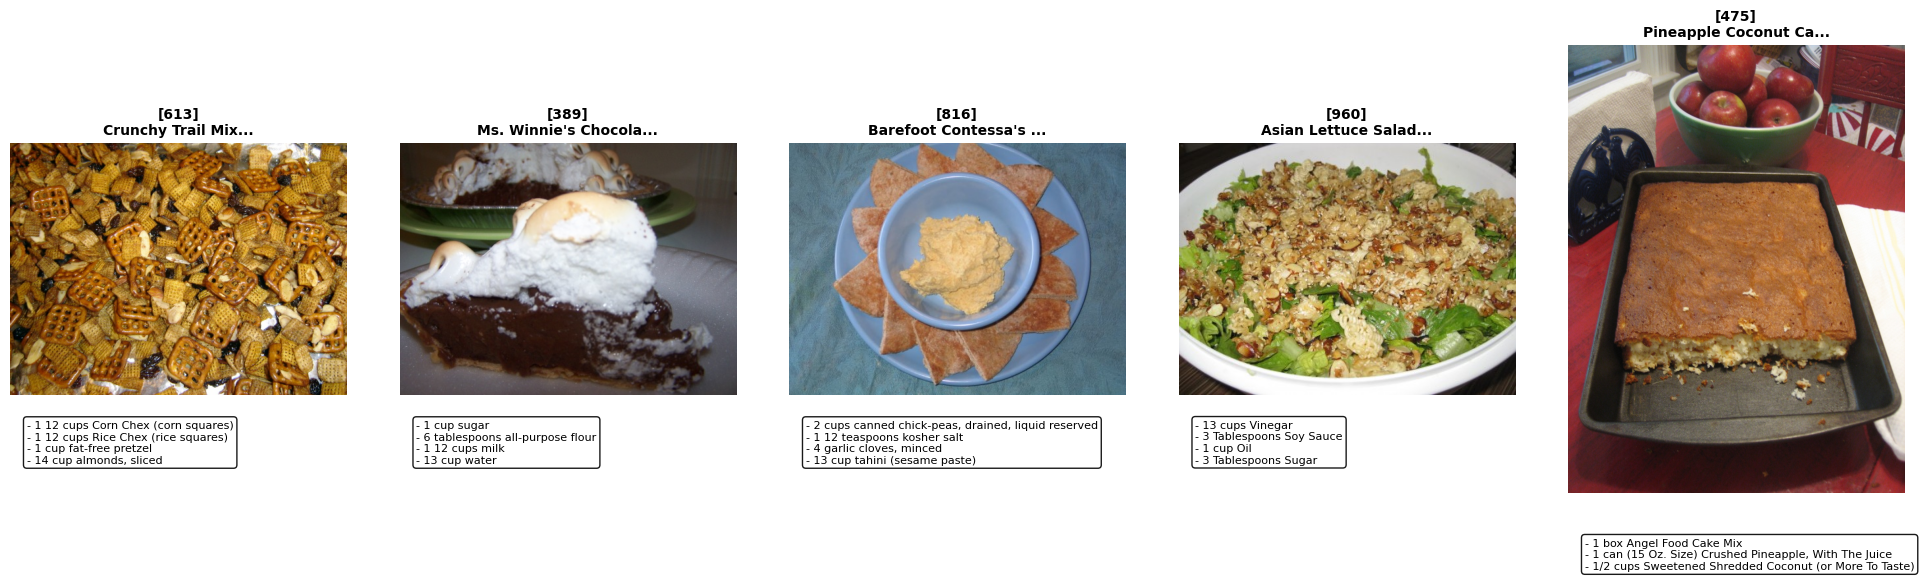


✨ READY TO TRAIN! Dataset is loaded and verified.


In [ ]:
import os
import json
import random
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import drive

# --- CONFIGURATION (Adjust if you move folders) ---
BASE_DIR = '/content/drive/MyDrive/ADA_Project'
DATASET_DIR = os.path.join(BASE_DIR, 'recipe1m_subset_balanced')
METADATA_PATH = os.path.join(DATASET_DIR, 'metadata.json')

def setup_environment():
    print("🚀 STARTING SETUP...")

    # 1. MOUNT DRIVE (With auto-fix for stuck connections)
    if not os.path.exists('/content/drive'):
        print("🔌 Connecting to Google Drive...")
        drive.mount('/content/drive')
    else:
        print("✅ Drive is already connected.")

    # 2. CHECK FOR METADATA (The "Ghost File" Fix)
    if not os.path.exists(METADATA_PATH):
        print("⚠️ metadata.json not found initially. Attempting Force-Refresh...")
        try:
            drive.flush_and_unmount()
            drive.mount('/content/drive', force_remount=True)
        except:
            pass

    # 3. VERIFY DATASET
    if os.path.exists(METADATA_PATH):
        file_size = os.path.getsize(METADATA_PATH) / (1024 * 1024) # Size in MB
        print(f"✅ SUCCESS: Dataset found! ({file_size:.2f} MB)")
        return True
    else:
        print(f"❌ CRITICAL ERROR: Could not find metadata.json at:")
        print(f"   {METADATA_PATH}")
        print("   Did you run the 'Connector/Recovery' script yesterday?")
        return False

def visualize_sample():
    """Pick 5 random recipes and show them to prove data integrity."""
    print("\n📊 Loading sample data...")
    try:
        with open(METADATA_PATH, 'r') as f:
            data = json.load(f)
    except Exception as e:
        print(f"❌ Error reading JSON: {e}")
        return

    print(f"   Total Library Size: {len(data)} recipes")
    samples = random.sample(data, 5)

    # Display
    fig, axes = plt.subplots(1, 5, figsize=(20, 6))
    if len(data) < 5: axes = [axes] # Handle tiny datasets

    for i, recipe in enumerate(samples):
        ax = axes[i]
        title = recipe.get('title', 'Untitled')
        img_path = recipe.get('local_path')
        class_id = recipe.get('class_id', 'Unknown')

        # Image
        if os.path.exists(img_path):
            try:
                img = Image.open(img_path)
                ax.imshow(img)
            except:
                ax.text(0.5, 0.5, "Corrupt Image", ha='center')
        else:
            ax.text(0.5, 0.5, "Image Missing", ha='center')

        # Text
        ax.set_title(f"[{class_id}]\n{title[:20]}...", fontsize=10, fontweight='bold')
        ax.axis('off')

        # Ingredients overlay
        ingredients = [ing['text'] for ing in recipe.get('ingredients', [])][:4]
        ing_text = "\n".join([f"- {x}" for x in ingredients])
        ax.text(0.05, -0.1, ing_text, transform=ax.transAxes,
                fontsize=8, verticalalignment='top',
                bbox=dict(boxstyle="round", fc="white", alpha=0.9))

    plt.tight_layout()
    plt.show()

# --- MAIN EXECUTION ---
if setup_environment():
    visualize_sample()
    print("\n✨ READY TO TRAIN! Dataset is loaded and verified.")
else:
    print("\n🛑 SETUP FAILED. Please check your folders.")

# Checking the balance of the dataset

📊 Loading dataset metadata...
✅ Analyzed 29932 recipes.

📈 DATASET STATISTICS:
   - Total Classes: 1048
   - Average Images per Class: 28.6
   - Min: 1 | Max: 47
   - Balance Score: 2.1% (Higher is better)


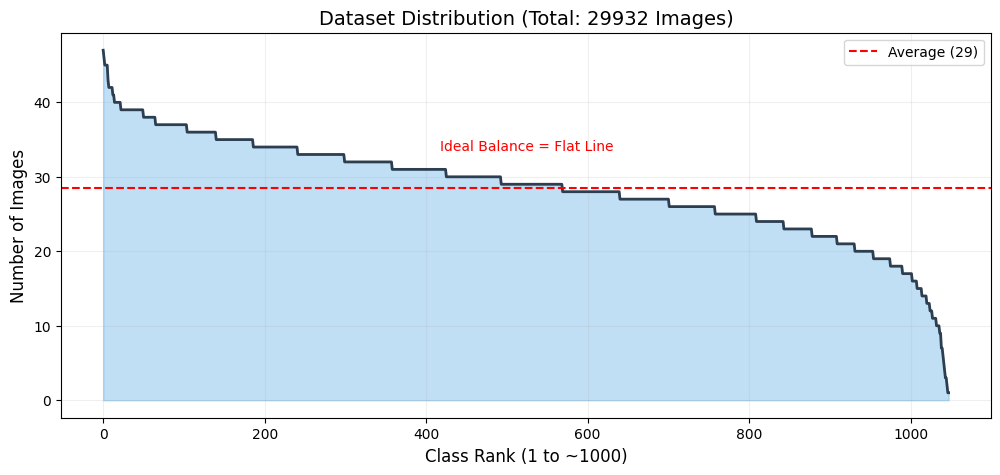

/tmp/ipython-input-3328480725.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Class', y='Count', data=top_20, palette='viridis')


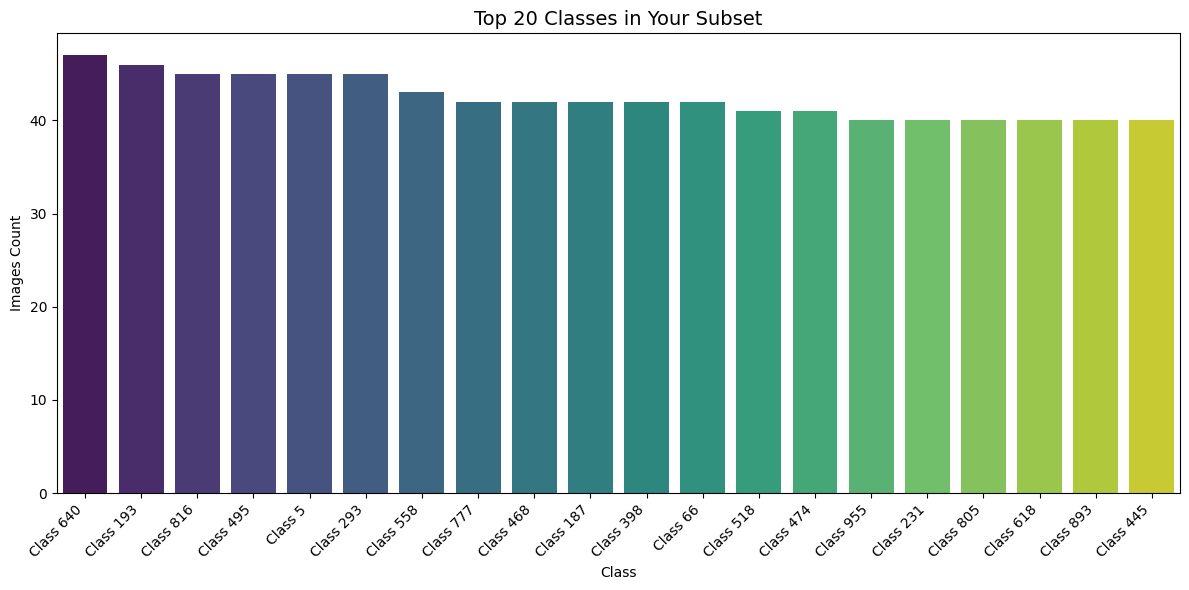

In [ ]:
import json
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import Counter

# --- CONFIGURATION ---
BASE_DIR = '/content/drive/MyDrive/ADA_Project'
METADATA_PATH = os.path.join(BASE_DIR, 'recipe1m_subset_balanced', 'metadata.json')
CLASS_NAMES_PATH = os.path.join(BASE_DIR, 'food101_classes_renamed.txt') # Optional

def main():
    print("📊 Loading dataset metadata...")
    if not os.path.exists(METADATA_PATH):
        print("❌ Error: metadata.json not found. Run the 'Connector' script first.")
        return

    with open(METADATA_PATH, 'r') as f:
        data = json.load(f)

    print(f"✅ Analyzed {len(data)} recipes.")

    # 1. Count Classes
    class_counts = Counter()
    for item in data:
        # Some recipes might miss a class ID if the original dataset was messy
        cid = item.get('class_id')
        if cid is not None:
            class_counts[cid] += 1

    if not class_counts:
        print("⚠️ No class IDs found! Did you merge the classes1M.pkl file correctly?")
        return

    # 2. Try to Map IDs to Names (for prettier graphs)
    class_names = {}
    if os.path.exists(CLASS_NAMES_PATH):
        with open(CLASS_NAMES_PATH, 'r') as f:
            names = [line.strip() for line in f.readlines()]
            # Create a map: ID (0) -> Name ("apple_pie")
            class_names = {i: name for i, name in enumerate(names)}

    # Prepare Data for Plotting
    # Convert Counter to DataFrame
    counts_list = []
    for cid, count in class_counts.items():
        name = class_names.get(cid, f"Class {cid}") # Use name if found, else "Class 123"
        counts_list.append({'Class': name, 'Count': count})

    df = pd.DataFrame(counts_list).sort_values('Count', ascending=False)

    # Stats
    avg_count = df['Count'].mean()
    min_count = df['Count'].min()
    max_count = df['Count'].max()

    print("\n📈 DATASET STATISTICS:")
    print(f"   - Total Classes: {len(df)}")
    print(f"   - Average Images per Class: {avg_count:.1f}")
    print(f"   - Min: {min_count} | Max: {max_count}")
    print(f"   - Balance Score: {(min_count/max_count)*100:.1f}% (Higher is better)")

    # --- PLOT 1: THE BALANCE CURVE (The Scientific Proof) ---
    plt.figure(figsize=(12, 5))
    plt.plot(range(len(df)), df['Count'].values, color='#2c3e50', linewidth=2)
    plt.fill_between(range(len(df)), df['Count'].values, color='#3498db', alpha=0.3)

    plt.axhline(y=avg_count, color='r', linestyle='--', label=f'Average ({avg_count:.0f})')

    plt.title(f"Dataset Distribution (Total: {len(data)} Images)", fontsize=14)
    plt.xlabel("Class Rank (1 to ~1000)", fontsize=12)
    plt.ylabel("Number of Images", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.2)

    # Add text annotation
    plt.text(len(df)*0.5, avg_count+5, "Ideal Balance = Flat Line",
             color='red', fontsize=10, ha='center')

    plt.show()



    # --- PLOT 2: TOP 20 CLASSES (The "Menu") ---
    plt.figure(figsize=(12, 6))
    top_20 = df.head(20)

    sns.barplot(x='Class', y='Count', data=top_20, palette='viridis')
    plt.title("Top 20 Classes in Your Subset", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Images Count")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

In [ ]:
import json
import pickle
import os
from collections import Counter

# --- CONFIGURATION ---
BASE_DIR = '/content/drive/MyDrive/ADA_Project'
LAYER1_PATH = os.path.join(BASE_DIR, 'layer1.json')
CLASS_PATH = os.path.join(BASE_DIR, 'classes1M.pkl')

# If the file is named differently in your drive (e.g., .txt), adjust here
if not os.path.exists(CLASS_PATH):
    # Try the manual upload path or .txt variant
    if os.path.exists('/content/classes1M.pkl'):
        CLASS_PATH = '/content/classes1M.pkl'
    elif os.path.exists(os.path.join(BASE_DIR, 'classes1M.pkl.txt')):
        CLASS_PATH = os.path.join(BASE_DIR, 'classes1M.pkl.txt')

def main():
    print("🕵️‍♀️ Inspecting Source Data for Food-101 (Classes 0-100)...")

    # 1. Load Classes
    if not os.path.exists(CLASS_PATH):
        print("❌ Error: classes1M.pkl not found.")
        return

    print("   Loading class map...")
    with open(CLASS_PATH, 'rb') as f:
        class_map = pickle.load(f, encoding='latin1')

    # 2. Filter for Food-101 (IDs 0 to 100)
    food101_ids = [rid for rid, cid in class_map.items() if cid <= 100]
    print(f"   Total recipes in Classes 0-100: {len(food101_ids)}")

    # 3. Check against Layer1 (Text)
    # We need to make sure these recipes actually have text/instructions
    print("   Verifying against Layer1 (Text)...")
    with open(LAYER1_PATH, 'r') as f:
        # Load just the IDs to save memory
        layer1_ids = set(item['id'] for item in json.load(f))

    valid_food101 = [rid for rid in food101_ids if rid in layer1_ids]

    count = len(valid_food101)
    print(f"\n✅ CONFIRMED CANDIDATES: {count}")

    if count >= 30000:
        print("🎉 FEASIBILITY: HIGH.")
        print(f"   You can easily build a 30k dataset (approx {count // 101} images per class).")
    else:
        print("⚠️ FEASIBILITY: LOW.")
        print(f"   You only have {count} total. You cannot reach 30k without using more classes.")

if __name__ == "__main__":
    main()

🕵️‍♀️ Inspecting Source Data for Food-101 (Classes 0-100)...
   Loading class map...
   Total recipes in Classes 0-100: 910471
   Verifying against Layer1 (Text)...

✅ CONFIRMED CANDIDATES: 910471
🎉 FEASIBILITY: HIGH.
   You can easily build a 30k dataset (approx 9014 images per class).


In [ ]:
import shutil
import os
import time

# --- CONFIGURATION ---
# Source (Drive)
DRIVE_LAYER1 = '/content/drive/MyDrive/ADA_Project/layer1.json'
DRIVE_CLASSES = '/content/drive/MyDrive/ADA_Project/classes1M.pkl'

# Destination (Local Temporary VM)
LOCAL_LAYER1 = '/content/layer1.json'
LOCAL_CLASSES = '/content/classes1M.pkl'

def copy_to_local():
    print("🚀 Copying files to local machine for speed...")
    start = time.time()

    # 1. Copy Layer 1 (The big one)
    if os.path.exists(DRIVE_LAYER1):
        print(f"   Copying layer1.json (This may take 30-60s)...")
        shutil.copy(DRIVE_LAYER1, LOCAL_LAYER1)
    else:
        print("❌ Error: Could not find layer1.json in Drive.")

    # 2. Copy Classes
    if os.path.exists(DRIVE_CLASSES):
        print(f"   Copying classes1M.pkl...")
        shutil.copy(DRIVE_CLASSES, LOCAL_CLASSES)

    end = time.time()
    print(f"✅ DONE! Transfer took {end - start:.1f} seconds.")
    print(f"   You can now access files at: {LOCAL_LAYER1}")

if __name__ == "__main__":
    copy_to_local()

🚀 Copying files to local machine for speed...
   Copying layer1.json (This may take 30-60s)...
   Copying classes1M.pkl...
✅ DONE! Transfer took 17.4 seconds.
   You can now access files at: /content/layer1.json


In [ ]:
import json
import pickle
import os

# USE LOCAL PATHS NOW
LAYER1_PATH = '/content/layer1.json'
CLASS_PATH = '/content/classes1M.pkl'

def main():
    print("🕵️‍♀️ Truth Test (Local Speed Mode)...")

    if not os.path.exists(LAYER1_PATH):
        print("❌ You need to run the 'Copy to Local' script above first!")
        return

    # 1. Load Classes
    with open(CLASS_PATH, 'rb') as f:
        class_map = pickle.load(f, encoding='latin1')

    # 2. Find IDs
    ids_0 = [rid for rid, cid in class_map.items() if cid == 0][:5]
    ids_55 = [rid for rid, cid in class_map.items() if cid == 55][:5]
    ids_100 = [rid for rid, cid in class_map.items() if cid == 100][:5]

    target_ids = set(ids_0 + ids_55 + ids_100)

    # 3. Load JSON (This will be SUPER fast now)
    print("   Reading JSON locally...")
    with open(LAYER1_PATH, 'r') as f:
        data = json.load(f)

    # Create quick lookup
    text_map = {item['id']: item['title'] for item in data if item['id'] in target_ids}

    # 4. Results
    print("\n--- 🥁 THE REVEAL ---")
    print(f"🔹 CLASS 0 (Expected: Apple Pie): {[text_map.get(i) for i in ids_0]}")
    print(f"🔹 CLASS 55 (Expected: Hot Dog): {[text_map.get(i) for i in ids_55]}")
    print(f"🔹 CLASS 100 (Expected: Waffles): {[text_map.get(i) for i in ids_100]}")

if __name__ == "__main__":
    main()

🕵️‍♀️ Truth Test (Local Speed Mode)...
   Reading JSON locally...

--- 🥁 THE REVEAL ---
🔹 CLASS 0 (Expected: Apple Pie): ['Stovepipe Bread ( Coffee Can Bread )', 'Artichoke Bruschetta', 'Wonder Brownies', 'Passover Chocolate Nut Cake', 'Chicken Nugget Casserole']
🔹 CLASS 55 (Expected: Hot Dog): ['No Time Chicken Pot Pie', 'Biscuit-Topped Chicken Pot Pie', 'Chicken Pot Pie', 'Chicken Pot Pie III', 'Curry Comfort Chicken Pot Pie']
🔹 CLASS 100 (Expected: Waffles): ['Chili Pesto Chicken Pasta', 'Cajun Chicken Pasta', 'Lemon-and-Dill Chicken Pasta', 'Piri Piri Chicken Pasta', 'Spicy and Creamy Chicken Pasta']


# Inferring the Classes

In [ ]:
import json
import os
import re
from collections import Counter
from tqdm.notebook import tqdm

# --- CONFIGURATION ---
BASE_DIR = '/content/drive/MyDrive/ADA_Project'
METADATA_PATH = os.path.join(BASE_DIR, 'recipe1m_subset_balanced', 'metadata.json')
OUTPUT_NAMES_PATH = os.path.join(BASE_DIR, 'inferred_class_names.json')

# Common words to ignore
STOPWORDS = set([
    'recipe', 'best', 'easy', 'the', 'with', 'and', 'for', 'of', 'in', 'a', 'to',
    'homemade', 'delicious', 'simple', 'quick', 'how', 'make', 'my', 'style', 'classic',
    'ever', 'from', 'version', 'ultimate', 'healthy', 'vegan', 'baked', 'sweet', 'ii', 'iii'
])

def get_most_common_phrase(titles):
    """Finds the 'Cluster Name' by looking for repeated 2-word phrases."""
    word_counter = Counter()
    bigram_counter = Counter()

    clean_titles = []
    for t in titles:
        # Clean text: lowercase, remove punctuation
        text = re.sub(r'[^a-z\s]', '', t.lower())
        words = [w for w in text.split() if len(w) > 2 and w not in STOPWORDS]
        clean_titles.append(words)

        # Count words and pairs
        word_counter.update(words)
        if len(words) >= 2:
            bigrams = [f"{words[i]} {words[i+1]}" for i in range(len(words)-1)]
            bigram_counter.update(bigrams)

    # Heuristic: If a bigram (e.g., "chicken pot") appears in >20% of recipes, use it
    if not bigram_counter and not word_counter: return "Misc Food"

    top_bigram, bigram_count = bigram_counter.most_common(1)[0] if bigram_counter else ("", 0)
    top_word, word_count = word_counter.most_common(1)[0] if word_counter else ("", 0)

    # If the bigram is strong, prefer it. Otherwise, use the single word.
    if bigram_count > (len(titles) * 0.2):
        return top_bigram.title() # "Chicken Pot"
    elif word_count > 0:
        return top_word.title()   # "Chicken"
    else:
        return "Misc/Varied"

def main():
    print("🕵️‍♀️ Deciphering Class Names...")

    if not os.path.exists(METADATA_PATH):
        print("❌ Error: metadata.json not found. Make sure your 30k dataset is ready.")
        return

    with open(METADATA_PATH, 'r') as f:
        data = json.load(f)

    # 1. Group titles by Class ID
    class_groups = {}
    for item in data:
        cid = item.get('class_id')
        title = item.get('title')
        if cid is not None and title:
            if cid not in class_groups: class_groups[cid] = []
            class_groups[cid].append(title)

    print(f"   Analyzing {len(class_groups)} classes...")

    # 2. Guess the names
    inferred_names = {}
    for cid, titles in tqdm(class_groups.items()):
        name = get_most_common_phrase(titles)
        inferred_names[cid] = name

    # 3. Save
    with open(OUTPUT_NAMES_PATH, 'w') as f:
        json.dump(inferred_names, f, indent=4)

    print(f"✅ Saved names to {OUTPUT_NAMES_PATH}")

    # 4. Show the truth regarding our mystery classes
    print("\n--- 🔍 MYSTERY SOLVED ---")
    print(f"Class 55 is actually: '{inferred_names.get(55, 'Unknown')}'")
    print(f"Class 100 is actually: '{inferred_names.get(100, 'Unknown')}'")
    print(f"Class 0 is actually: '{inferred_names.get(0, 'Unknown')}'")

if __name__ == "__main__":
    main()

🕵️‍♀️ Deciphering Class Names...
   Analyzing 1048 classes...


  0%|          | 0/1048 [00:00<?, ?it/s]

✅ Saved names to /content/drive/MyDrive/ADA_Project/inferred_class_names.json

--- 🔍 MYSTERY SOLVED ---
Class 55 is actually: 'Pot Pie'
Class 100 is actually: 'Chicken Pasta'
Class 0 is actually: 'Chicken'


# Checking the Classes

In [ ]:
import json
import os
import pandas as pd
from google.colab import data_table

# --- CONFIGURATION ---
BASE_DIR = '/content/drive/MyDrive/ADA_Project'
METADATA_PATH = os.path.join(BASE_DIR, 'recipe1m_subset_balanced', 'metadata.json')

def main():
    print("📊 Generating Class Inspection Table...")

    if not os.path.exists(METADATA_PATH):
        print("❌ Error: metadata.json not found.")
        return

    with open(METADATA_PATH, 'r') as f:
        data = json.load(f)

    # 1. Group Recipes by Class
    class_buckets = {}
    for item in data:
        cid = item.get('class_id')
        title = item.get('title')

        if cid is not None:
            if cid not in class_buckets:
                class_buckets[cid] = []
            class_buckets[cid].append(title)

    # 2. Build the DataFrame
    rows = []
    # Sort by Class ID so it's easy to find Class 0, 55, 100
    for cid in sorted(class_buckets.keys()):
        titles = class_buckets[cid]

        # Grab up to 3 samples
        t1 = titles[0] if len(titles) > 0 else "-"
        t2 = titles[1] if len(titles) > 1 else "-"
        t3 = titles[2] if len(titles) > 2 else "-"
        t4 = titles[3] if len(titles) > 3 else "-"
        rows.append({
            "Class ID": cid,
            "Count": len(titles),
            "Example 1": t1,
            "Example 2": t2,
            "Example 3": t3,
            "Example 4": t4
        })

    df = pd.DataFrame(rows)

    # 3. Interactive Display
    print(f"✅ Analyzed {len(df)} unique classes.")
    print("👇 Use the table below to filter and search (e.g., search for '55' or 'Pizza')")

    # This enables the fancy sortable/searchable table in Colab
    data_table.enable_dataframe_formatter()
    display(df)

if __name__ == "__main__":
    main()

📊 Generating Class Inspection Table...
✅ Analyzed 1048 unique classes.
👇 Use the table below to filter and search (e.g., search for '55' or 'Pizza')


,Class ID,Count,Example 1,Example 2,Example 3,Example 4
0,0,28,Wonder Brownies,Chicken Nugget Casserole,Drop Biscuits,Himalayan Red Rice
1,1,32,Chewy Pumpkin Peanut Butter Cookies,Peanut Butter Protein Cookies,Chocolate Peanut Butter Bites,Chocolate Peanut Butter Cookies
2,2,29,Sherry Crema Catalana Ice Cream with Honeyed Figs,White Russian Ice Cream,Peach Pie Ice Cream Float,South Beach Diet Faux Ice Cream
3,3,32,Mint Chocolate Chip Pillows,Easiest Stay Soft Chocolate Chip Cookies That ...,Chocolate Chip Cheesecake Bars,Banana Chocolate Chip Loaf
4,4,27,Sausage and Sweet Potato Chowder,Roasted Sweet Potato Salad,Cajun Cutlets With Sweet Potato Mash and Tomat...,Oven-Roasted Sweet Potato Fries
...,...,...,...,...,...,...
1043,1043,29,Coffee Bean and Peppercorn Steak,Swordfish Steaks Broiled with Maitre d'Hotel B...,Surf N Turf 2.0: Strip Steaks With Bouillabais...,Steakhouse Sirloin with Scallion Fries and Salad
1044,1044,10,Stuffed Avocado California Style (Pseudo Sushi),Minado's Perfect Sushi Rice,Salmon Sushi,Pasta Sushi Is A Thing? Yes! Heres The.
1045,1045,30,Flatbread Tacos,Pork Carnitas Tacos,Shredded Chicken for Tacos,Fabulous Pork Tacos Recipe
1046,1046,25,Tiramisu,Tiramisu Smoothie,Strawberry Tiramisu (For Those in Greece),Tiramisu Martini


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Class ID'].plot(kind='hist', bins=20, title='Class ID')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Count'].plot(kind='hist', bins=20, title='Count')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='index', y='Class ID', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Class ID', y='Count', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Count']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Count')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Class ID']
  ys = series['Count']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('Class ID', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Class ID')
_ = plt.ylabel('Count')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Class ID']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Class ID'}, axis=1)
              .sort_values('Class ID', ascending=True))
  xs = counted['Class ID']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('Class ID', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Class ID')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_9['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['Class ID'].plot(kind='line', figsize=(8, 4), title='Class ID')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['Count'].plot(kind='line', figsize=(8, 4), title='Count')
plt.gca().spines[['top', 'right']].set_visible(False)

## Check if there are no duplicates in recipes like Chiken Tikka Masala (991)

In [ ]:
import json
import os

BASE_DIR = '/content/drive/MyDrive/ADA_Project'
METADATA_PATH = os.path.join(BASE_DIR, 'recipe1m_subset_balanced', 'metadata.json')

def main():
    print("🕵️‍♀️ Duplicate Detective...")

    with open(METADATA_PATH, 'r') as f:
        data = json.load(f)

    # Find recipes in Class 991 (or whatever class you saw in the table)
    # The screenshot shows Class ID 991
    target_class = 991
    recipes = [r for r in data if r.get('class_id') == target_class]

    print(f"Found {len(recipes)} recipes in Class {target_class}.")

    # Compare the first 3
    for i, r in enumerate(recipes[:3]):
        print(f"\n--- Recipe #{i+1}: {r['title']} ---")
        ingredients = [ing['text'] for ing in r['ingredients']]
        print(f"   Ingredients: {ingredients[:5]}...") # Show first 5 ingredients

if __name__ == "__main__":
    main()

🕵️‍♀️ Duplicate Detective...
Found 31 recipes in Class 991.

--- Recipe #1: Chicken Tikka Masala ---
   Ingredients: ['1/2 teaspoons Ground Coriander', '1/2 teaspoons Cumin Seeds', '1 cup Plain Yogurt (not Non-fat)', '2 cloves Garlic, Smashed With A Knife', '1 whole Lime, Juiced']...

--- Recipe #2: Chicken Tikka Masala ---
   Ingredients: ['1 Tablespoon Olive Oil', '2 pounds Boneless Chicken Breasts, Cubed', '1/2 teaspoons Curry Powder', '2 Tablespoons Butter', '1/2 whole Onion, finely chopped']...

--- Recipe #3: Chicken Tikka Masala ---
   Ingredients: ['4 boneless chicken breasts (cut into about about 1 to 1-1/2-inch cubes, can use 5 breasts)', '4 -5 wooden skewers (soaked in cold water for a minimum of 30 minutes)', '1 cup full-fat plain yogurt', '1 tablespoon lemon juice', '1 teaspoon cinnamon']...


We now have a dataset of almost 30000, where we created the labels for the recipes They are somewhat correct. We have images, their categories and their ingredient list and recipes.

# TRAINING START